## Predicting delay duration based on weather conditions

In [1]:
import os
from pyspark.sql import SparkSession

jar_folder = "/opt/extra_jars"
jars = [os.path.join(jar_folder, f) for f in os.listdir(jar_folder) if f.endswith('.jar')]
jars_string = ",".join(jars)

if 'spark' in locals():
    spark.stop()

spark = (SparkSession.builder
    .appName("RegressionWeatherAndDelay")
    .master("spark://spark-master:7077")
    .config("spark.jars", jars_string)
    .config("spark.mongodb.read.connection.uri", "mongodb://mongodb:27017/big_data_austria")
    .getOrCreate())


df = (spark.read
    .format("mongodb")
    .option("collection", "merged_weather_incidents")
    .load())


def save_plot(name):
    full_path = os.path.join("plots", f"{name}.png")
    plt.savefig(full_path)
    print(f"Saved: {full_path}")

# save_plot("mein_neuer_plot")


### Data prep and filtering

In [2]:
from pyspark.sql import functions as F

# Filter für existierende Delays und Ausschluss von > 15 Stunden (54.000 Sekunden)
df_reg = df.filter(
    (F.col("diff_seconds").isNotNull()) & 
    (F.col("diff_seconds") > 0) & 
    (F.col("diff_seconds") <= 54000)
)

features_to_keep = [
    "air_pressure", "precipitation", "relative_humidity", 
    "sunshine_duration", "temperature", "wind_speed", 
    "weekday_name", "diff_seconds"
]

#Fill empty features with 0
df_ml = df_reg.select(features_to_keep).na.fill(0)

train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

### Correlation analysis

Saved: plots/linear_correlation_weather_delaytime_heatmap.png


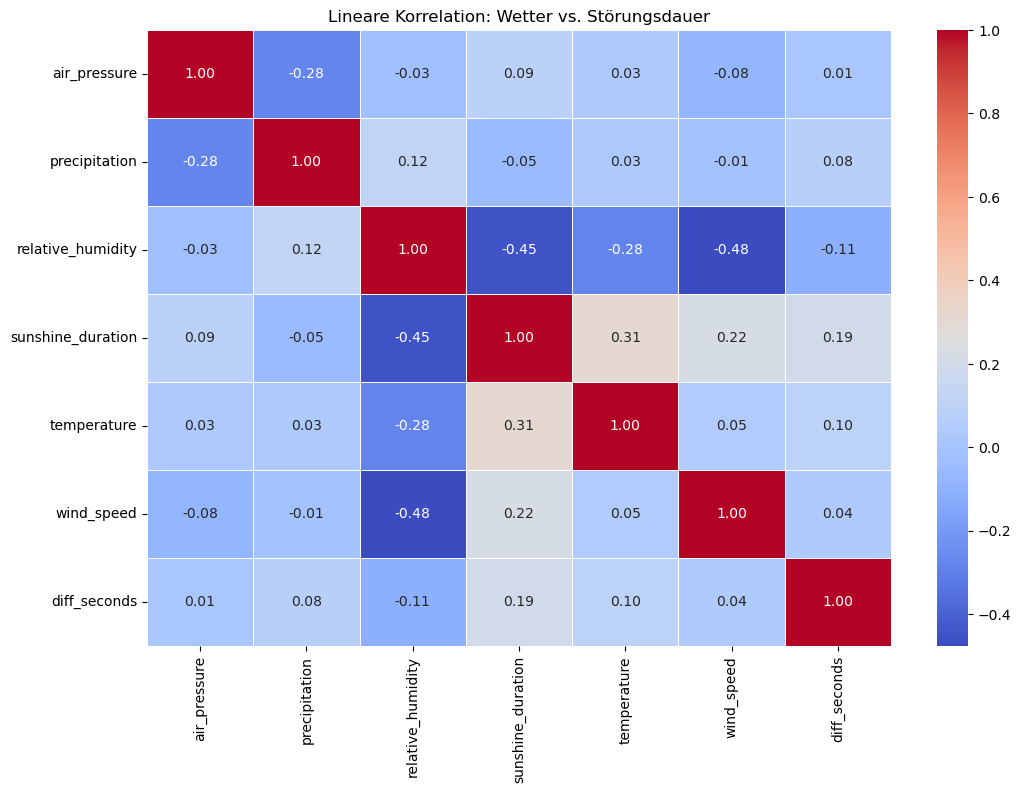

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

pandas_df = df_ml.toPandas()
corr_matrix = pandas_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Lineare Korrelation: Wetter vs. Störungsdauer')

save_plot("linear_correlation_weather_delaytime_heatmap")
plt.show()

## ML Pipeline definition

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Wochentag: Text -> Index -> Vector
indexer = StringIndexer(inputCol="weekday_name", outputCol="weekday_index", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="weekday_index", outputCol="weekday_vec")

# Features bündeln (Wetter + Wochentag-Vektor)
input_cols = [
    "air_pressure", "precipitation", "relative_humidity", 
    "sunshine_duration", "temperature", "wind_speed", "weekday_vec"
]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Regressor definieren
rf = RandomForestRegressor(featuresCol="features", labelCol="diff_seconds", numTrees=100, seed=42)

# Pipeline zusammenstellen
pipeline = Pipeline(stages=[indexer, encoder, assembler, rf])

### Crossvalidation and training

In [10]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="diff_seconds", 
    predictionCol="prediction", 
    metricName="rmse"
)

#Hyperparametertuning WE ARE TRAINING 37 Model
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [ 100, 120, 150, 170 ])
             .addGrid(rf.maxDepth, [10, 12, 20])
             .build())

#CrossValidator Setup
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    seed=42)

cvModel = cv.fit(train_df)

## Results

In [11]:
#Optimal Model
best_pipeline_model = cvModel.bestModel

best_rf = best_pipeline_model.stages[-1]

print(f"Beste Anzahl Bäume: {best_rf.getNumTrees}")
print(f"Beste Tiefe: {best_rf.getOrDefault('maxDepth')}")

# Metriken auf den Testdaten berechnen
predictions = cvModel.transform(test_df)
rmse = evaluator.evaluate(predictions) #estimated) standard error of regression    low = good :)
r2 = evaluator.setMetricName("r2").evaluate(predictions) # low = not good :(

print(f"RMSE (Test-Set): {rmse/60:.2f} Minuten")
print(f"R2-Score: {r2:.4f}")

Beste Anzahl Bäume: 120
Beste Tiefe: 12
RMSE (Test-Set): 247.55 Minuten
R2-Score: 0.1300


## Actual vs. predicted delay in minutes

In [12]:
predictions.select(
    F.round(F.col("diff_seconds") / 60, 2).alias("Real_Min"), 
    F.round(F.col("prediction") / 60, 2).alias("Vorhersage_Min")
).show(5)

+--------+--------------+
|Real_Min|Vorhersage_Min|
+--------+--------------+
|   625.0|        323.22|
|   49.57|         431.8|
|    80.0|        267.38|
|   770.0|        729.63|
|   775.0|         756.4|
+--------+--------------+
only showing top 5 rows



## Residual plot

Visualizing the differences between the predicted and actual delay duration.

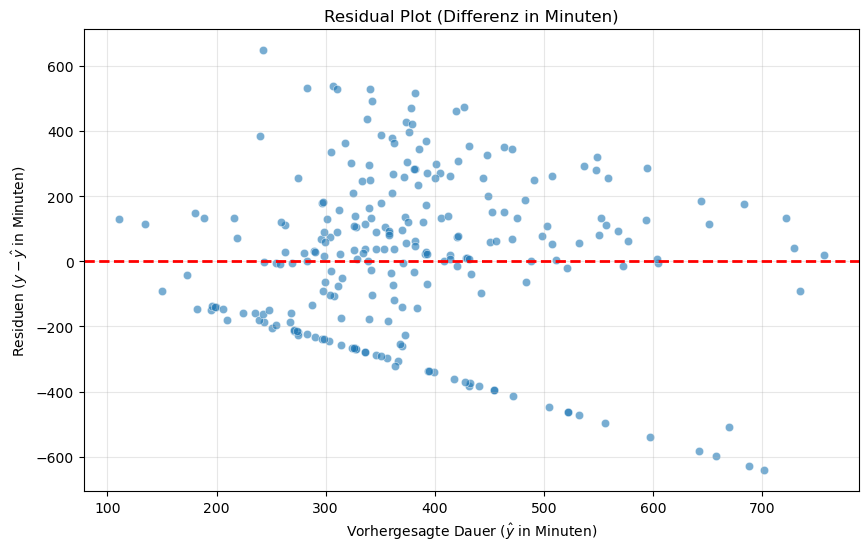

In [13]:
res_pdf = predictions.select(
    (F.col("prediction") / 60).alias("predicted_min"),
    ((F.col("diff_seconds") - F.col("prediction")) / 60).alias("residual_min")
).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="predicted_min", y="residual_min", data=res_pdf, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residual Plot (Differenz in Minuten)')
plt.xlabel('Vorhergesagte Dauer ($\hat{y}$ in Minuten)')
plt.ylabel('Residuen ($y - \hat{y}$ in Minuten)')
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_41730/3792068458.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Wichtigkeit', y='Faktor', data=df_final, palette='viridis')


Saved: plots/feature_importance_average_weekday.png


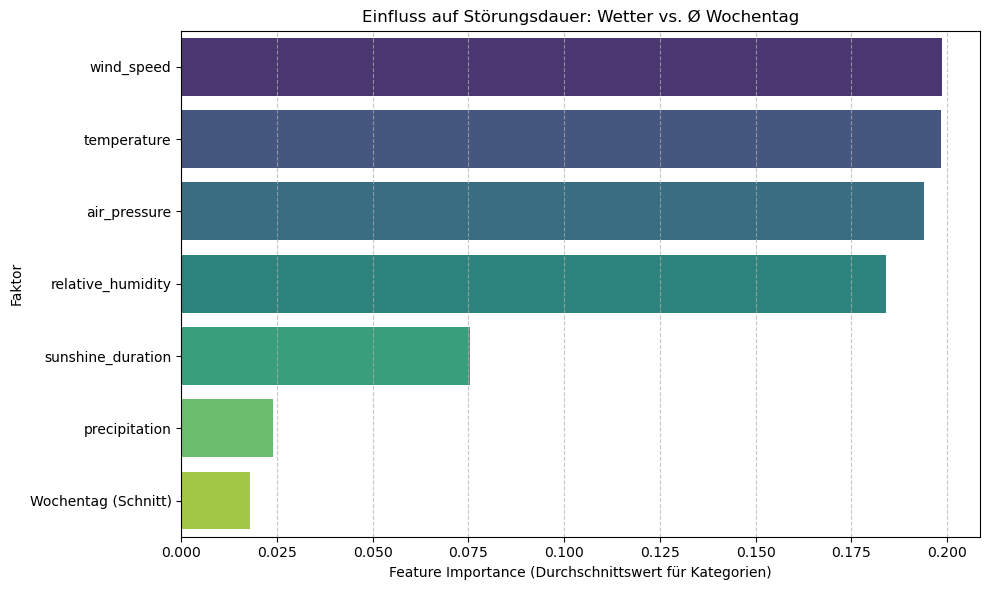

In [14]:
import pandas as pd

#Namen und Importances extrahieren
transformed_data = cvModel.bestModel.transform(test_df)
feature_metadata = transformed_data.schema["features"].metadata["ml_attr"]["attrs"]

all_feature_names = []
if "numeric" in feature_metadata:
    all_feature_names.extend([x["name"] for x in feature_metadata["numeric"]])
if "binary" in feature_metadata:
    all_feature_names.extend([x["name"] for x in feature_metadata["binary"]])

importances = cvModel.bestModel.stages[-1].featureImportances.toArray()
df_importance = pd.DataFrame({'Faktor': all_feature_names, 'Wichtigkeit': importances})

is_weekday = df_importance['Faktor'].str.contains('weekday_vec')
df_weather = df_importance[~is_weekday].copy()
weekday_avg = df_importance.loc[is_weekday, 'Wichtigkeit'].mean()

df_final = pd.concat([
    df_weather, 
    pd.DataFrame({'Faktor': ['Wochentag (Schnitt)'], 'Wichtigkeit': [weekday_avg]})
])

# 3. Sortieren und Plotten
df_final = df_final.sort_values(by='Wichtigkeit', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Wichtigkeit', y='Faktor', data=df_final, palette='viridis')

plt.title('Einfluss auf Störungsdauer: Wetter vs. Ø Wochentag')
plt.xlabel('Feature Importance (Durchschnittswert für Kategorien)')
plt.ylabel('Faktor')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
save_plot("feature_importance_average_weekday")
plt.show()

Saved: plots/prediction_vs_reality_scatter.png


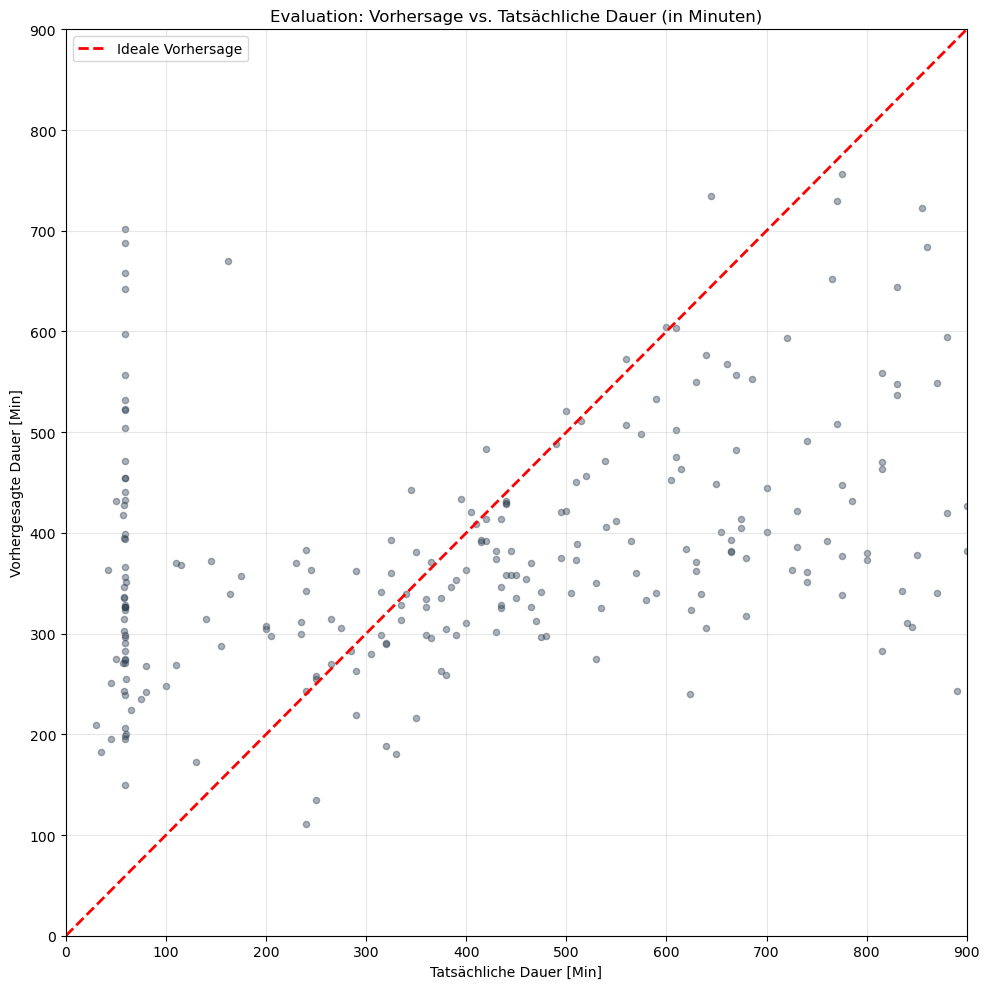

In [15]:
from pyspark.sql import functions as F

#Nutze cvModel (dein Best Model aus der Cross-Validation)
pdf = cvModel.transform(test_df).select(
    (F.col("diff_seconds") / 60).alias("Real_Min"),
    (F.col("prediction") / 60).alias("Vorhersage_Min")
).toPandas()

plt.figure(figsize=(10, 10))

# Scatterplot
plt.scatter(pdf['Real_Min'], pdf['Vorhersage_Min'], alpha=0.4, color='#2c3e50', s=20)

# Ideale Linie (Vorhersage == Realität)
max_val = max(pdf['Real_Min'].max(), pdf['Vorhersage_Min'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Ideale Vorhersage')

plt.title('Evaluation: Vorhersage vs. Tatsächliche Dauer (in Minuten)')
plt.xlabel('Tatsächliche Dauer [Min]')
plt.ylabel('Vorhergesagte Dauer [Min]')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Achsen begrenzen auf deine 15 Stunden (900 Min)
plt.xlim(0, 900)
plt.ylim(0, 900)

plt.tight_layout()
save_plot("prediction_vs_reality_scatter")
plt.show()